##Sentiment analysis with Keras##

This notebook is a sentiment analysis project according to the article on realpython.com : https://realpython.com/python-keras-text-classification/

First we import the sentences from the files downloaded beforehand into the dataframes

In [1]:
import pandas as pd

filepath_dict = {'yelp':   'sentiment labelled sentences/yelp_labelled.txt',
                 'amazon': 'sentiment labelled sentences/amazon_cells_labelled.txt',
                 'imdb':   'sentiment labelled sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In the second step we split the data into testing and training sets

In [2]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y=df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,y,test_size=0.25, random_state = 1000)

Next we create encoded senteces using sklearn's CountVectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [4]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)


Accuracy: 0.796


In [5]:
sentences[0:5]

array(['Wow... Loved this place.', 'Crust is not good.',
       'Not tasty and the texture was just nasty.',
       'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
       'The selection on the menu was great and so were the prices.'],
      dtype=object)

In [6]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
from keras.backend import clear_session
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                17150     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17,161
Trainable params: 17,161
Non-trainable params: 0
_________________________________________________________________


In [8]:
clear_session()
history = model.fit(X_train, y_train,
                    epochs=40,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

c:\Users\kajka\Documents\NLP_temporal\pyenv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [9]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8040


In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

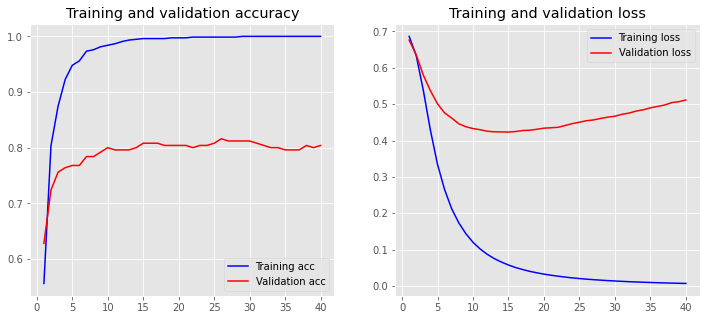

In [11]:
plot_history(history)

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])


Of all the dishes, the salmon was the best, but all were great.
[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [13]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])



[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [14]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           87350     
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5067
Testing Accuracy:  0.4800


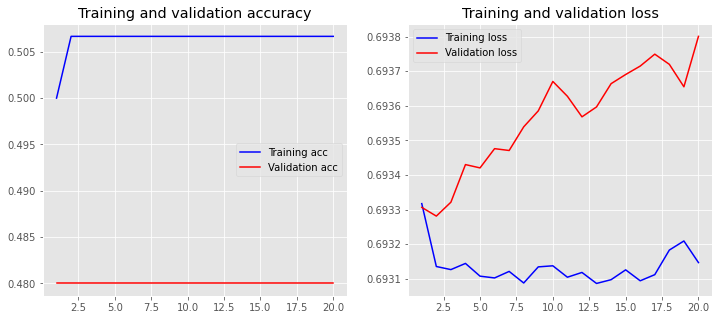

In [15]:
clear_session()
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [16]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8040


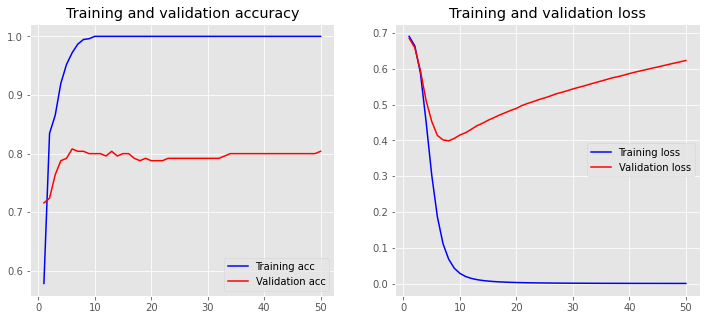

In [17]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [18]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [19]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove_word_embeddings/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [20]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9507727532913566

In [21]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 521
Non-trainable params: 87,350
_________________________________________________________________


Training Accuracy: 0.7413
Testing Accuracy:  0.7000


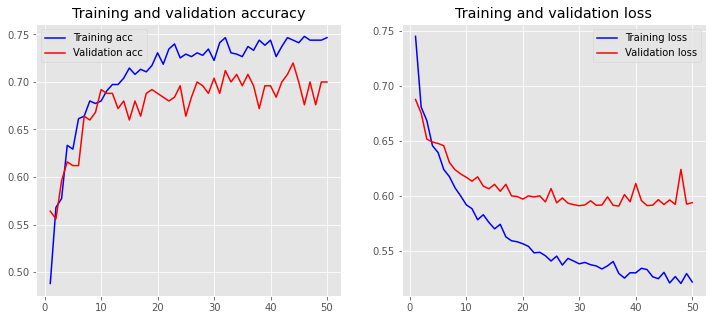

In [22]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [23]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           87350     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [25]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary(5)

Training Accuracy: 0.9227
Testing Accuracy:  0.7480


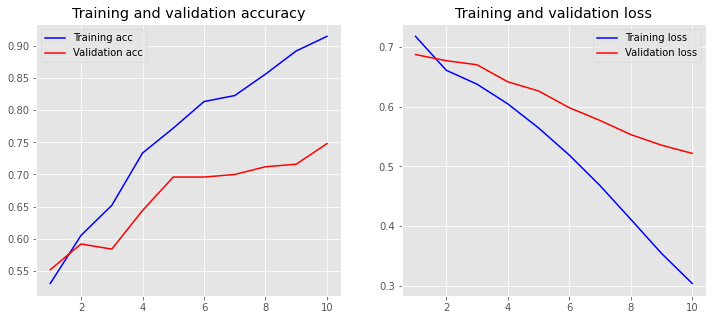

In [24]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [25]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [27]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


C:\Users\kajka\AppData\Local\Temp/ipykernel_13860/56598350.py:39: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model,
